# Thesis' code

## Part 1

### 1.1 Downloading and preprocessing the data 

In [30]:
import os
import pandas as pd
import numpy as np
import datetime
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

pd.plotting.register_matplotlib_converters()


In [31]:
ticker_list = ['SBER', 'GAZP', 'LKOH', 'NVTK', 'ROSN', 'GMKN', 'TATN', 'SNGS'] 
ticker_to_index = {'SBER': 0, 'GAZP': 1, 'LKOH': 2, 'NVTK': 3, 'ROSN': 4, 'GMKN': 5, 'TATN': 6, 'SNGS': 7}
other_tickers = ['SPX', 'BZ']
other_returns = ['RGBI', 'RTSI']

In [32]:
def get_raw_data(ticker, startdate='20131201', starttime='10:00:00', endtime='18:45:00'):
    # this function takes a string with ticker name as an argument 
    # returns the table with raw data on that ticker
    cwd = os.getcwd()
    address = cwd + '/data_files/' + ticker
    files = os.listdir(address)
    data = list()
    for f in files:
        if f.endswith('.csv'):
            data_f = pd.read_csv(address+'/'+f, sep = ';')
            data_f['<DATE>']=pd.to_datetime(data_f['<DATE>'], format ="%y%m%d")
            data_f = data_f[data_f['<TIME>']!=0]
            data_f['<TIME>']=pd.to_datetime(data_f['<TIME>'], format ="%H%M%S").dt.time
            data.append(data_f)
    data = pd.concat(data, ignore_index=True, axis=0)
    data.rename(columns = {'<TICKER>':'ticker', '<PER>':'per', '<DATE>':'date', '<TIME>':'time',
                           '<OPEN>':'open', '<HIGH>':'high', '<LOW>':'low', '<CLOSE>':'close', '<VOL>':'vol'},
                inplace=True)
    data.sort_values(['date', 'time'], inplace = True)
    starttime = datetime.datetime.strptime(starttime, '%H:%M:%S').time()
    endtime = datetime.datetime.strptime(endtime, '%H:%M:%S').time()

    return data.query('date >= @startdate and time >= @starttime and time <= @endtime')

In [33]:
def get_other_rv(ticker, startdate = '20131201', starttime = '0:00:00', endtime = '23:59:00', 
                 obs_startdate = '20140101', minn = 40):
    # this function takes a string with a name of ticker ('SPX' or 'BZ') 
    # whose rv will be used as an additionalfeature
    # returns the table with date and rv (lagged)
    
    raw_data = get_raw_data(ticker, startdate, starttime, endtime)
    
    full_data = raw_data.assign(returns = lambda d: (np.log(d.open)-np.log(d.close))**2)
    data = full_data.groupby('date').agg(ticker=('ticker', lambda x: x.iloc[0]),
                                         rv_d=('returns', 'sum'),
                                         n=('ticker', lambda x: len(x)),
                                         t_first = ('time', lambda x: x.iloc[0]),
                                         t_last = ('time', lambda x: x.iloc[-1]))
    
    data = data[data.n > minn]
    data.rv_d = np.log(data.rv_d)
    data.reset_index(inplace=True)
    
    new_name = 'rv_' + data.ticker.iloc[0].lower()
    data[new_name] = data.rv_d.shift()
    return data.query('date >= @obs_startdate')[['date', new_name]]


In [34]:
def get_other_logr(ticker, startdate='20131201', obs_startdate='20140101'):
    # this function takes a string with a name of ticker ('RGBI', 'RTSI') 
    # whose returns will be used as an additional feature
    # returns the table with date and rv (lagged)

    cwd = os.getcwd()
    address = cwd + '/data_files/' + ticker
    files = os.listdir(address)
    data = list()
    for f in files:
        if f.endswith('.csv'):
            data_f = pd.read_csv(address+'/'+f, sep = ';')
            data_f['<DATE>']=pd.to_datetime(data_f['<DATE>'], format ="%y%m%d")
            data.append(data_f)
    data = pd.concat(data, ignore_index=True, axis=0)
    data.rename(columns = {'<TICKER>':'ticker', '<PER>':'per', '<DATE>':'date', '<TIME>':'time',
                           '<OPEN>':'open', '<HIGH>':'high', '<LOW>':'low', '<CLOSE>':'close', '<VOL>':'vol'},
                inplace=True)
    data.sort_values(['date'], inplace = True)

    data =  data.query('date >= @startdate')
    
    new_name = 'r_' + data.ticker.iloc[0].lower()
    data[new_name] = (np.log(data.close) - np.log(data.close).shift()).shift()


    return data.query('date >= @obs_startdate')[['date', new_name]]

In [35]:
other_data_list = []
# collecting the common additional features

for t in other_tickers:
    other_data_list.append(get_other_rv(t))
    
for t in other_returns:
    other_data_list.append(get_other_logr(t))

In [47]:
def preprocess_data(raw_data, startdate='20140101', minn=20, other_data=other_data_list):
    # this function computes daily data from intraday
    # and creates a dataset, including the additional features used in the extended version
    
    full_data = raw_data.assign(returns = lambda d: (np.log(d.open)-np.log(d.close))**2)
    data = full_data.groupby('date').agg(ticker=('ticker', lambda x: x.iloc[0]),
                                         per=('per', lambda x: x.iloc[0]),
                                         open_d=('open', lambda x: x.iloc[0]), 
                                         high_d=('high', 'max'),
                                         low_d=('low', 'min'),
                                         close_d=('close', lambda x: x.iloc[-1]),
                                         vol_d=('vol', 'sum'),
                                         rv_d=('returns', 'sum'),
                                         n=('ticker', lambda x: len(x)),
                                         t_first = ('time', lambda x: x.iloc[0]),
                                         t_last = ('time', lambda x: x.iloc[-1]))
    data.rv_d = np.log(data.rv_d)
    data.reset_index(inplace=True)
    data['y'] = data.date.dt.year
    data['m'] = data.date.dt.month
    data['d'] = data.date.dt.day
    data['s'] = (data['m']//3) % 4
    data['q'] = (data['m']-1)//3
    data[['iso_y','iso_w','iso_d']] = data.date.dt.isocalendar()
    
    data['rv_d_past'] = data.rv_d.shift()
    data['rv_w_past'] = data.rv_d.rolling(5).mean().shift()
    data['rv_m_past'] = data.rv_d.rolling(21).mean().shift()
    
    data['high_low_past'] = (data.high_d - data.low_d).shift()
    data['overnight_past'] = (np.log(data.open_d) - np.log(data.close_d.shift())).shift()
    
    for variable in other_data:
        data = data.merge(variable, how='left', on=['date'])
      
    data.rv_d.dropna(inplace=True)
    data.ffill(inplace=True)

    return data.query('date >= @startdate and n > @minn').dropna()

In [48]:
data_list = []
# collecting the preprocessed data to a list
for t in ticker_list:
    data_list.append(preprocess_data(get_raw_data(t)))
    

### 1.2 Saving the data 

In [41]:
col_names = ['date', 'y', 'm', 'rv_d', 
             'rv_d_past', 'rv_w_past', 'rv_m_past', 
             'high_low_past', 'overnight_past',
             'rv_spx', 'rv_bz',
             'r_rgbi', 'r_rtsi']

for i in range(len(ticker_list)):
    path = 'dataset_vol/' + ticker_list[i] + '.csv'
    data_list[ticker_to_index[ticker_list[i]]][col_names].to_csv(path, sep=';', index=False, header=True)


### 1.3 Loading the data 

In [5]:
ticker_list = ['SBER', 'GAZP', 'LKOH', 'NVTK', 'ROSN', 'GMKN', 'TATN', 'SNGS'] 
ticker_list.sort()

In [6]:
# while in this notebook loading could be avoided, it is used in the second notebook
# the functions are identical

def load_data(ticker, startdate = '20140101', enddate = '20240701'):
    # this function takes a ticker name (string) as an argument 
    # returns the table with data on that ticker
    
    path = 'dataset_vol/' + ticker + '.csv'
    data = pd.read_csv(path, sep = ';')
    data['date']=pd.to_datetime(data['date'])

    return data.query('date >= '+startdate+'and date < '+enddate)


data = {t: load_data(t) for t in ticker_list}


### 1.4 Plotting the data 

In [16]:
# here, rv-set corresponds to the base set, all_set to extended set
base_set = ['rv_d_past', 'rv_w_past', 'rv_m_past']
extended_set = base_set + ['high_low_past', 'overnight_past', 'rv_spx', 'rv_bz', 'r_rgbi', 'r_rtsi']


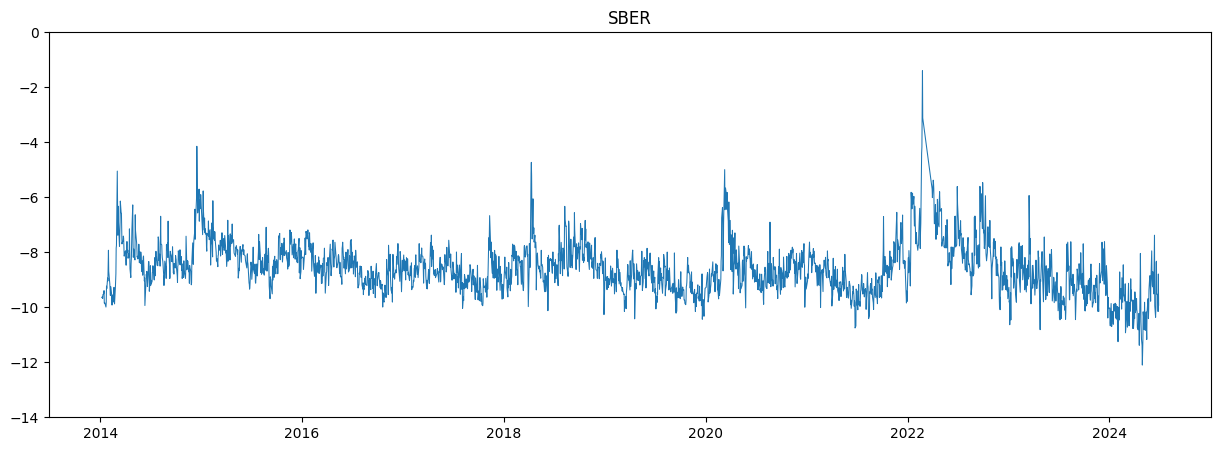

In [10]:
# plotting an example of the log daily rv, using SBER
plt.figure(figsize=(15,5))
plt.plot(data['SBER'].date, data['SBER'].rv_d, linewidth=0.75)
plt.title('SBER')
plt.ylim(-14, 0)
plt.show()

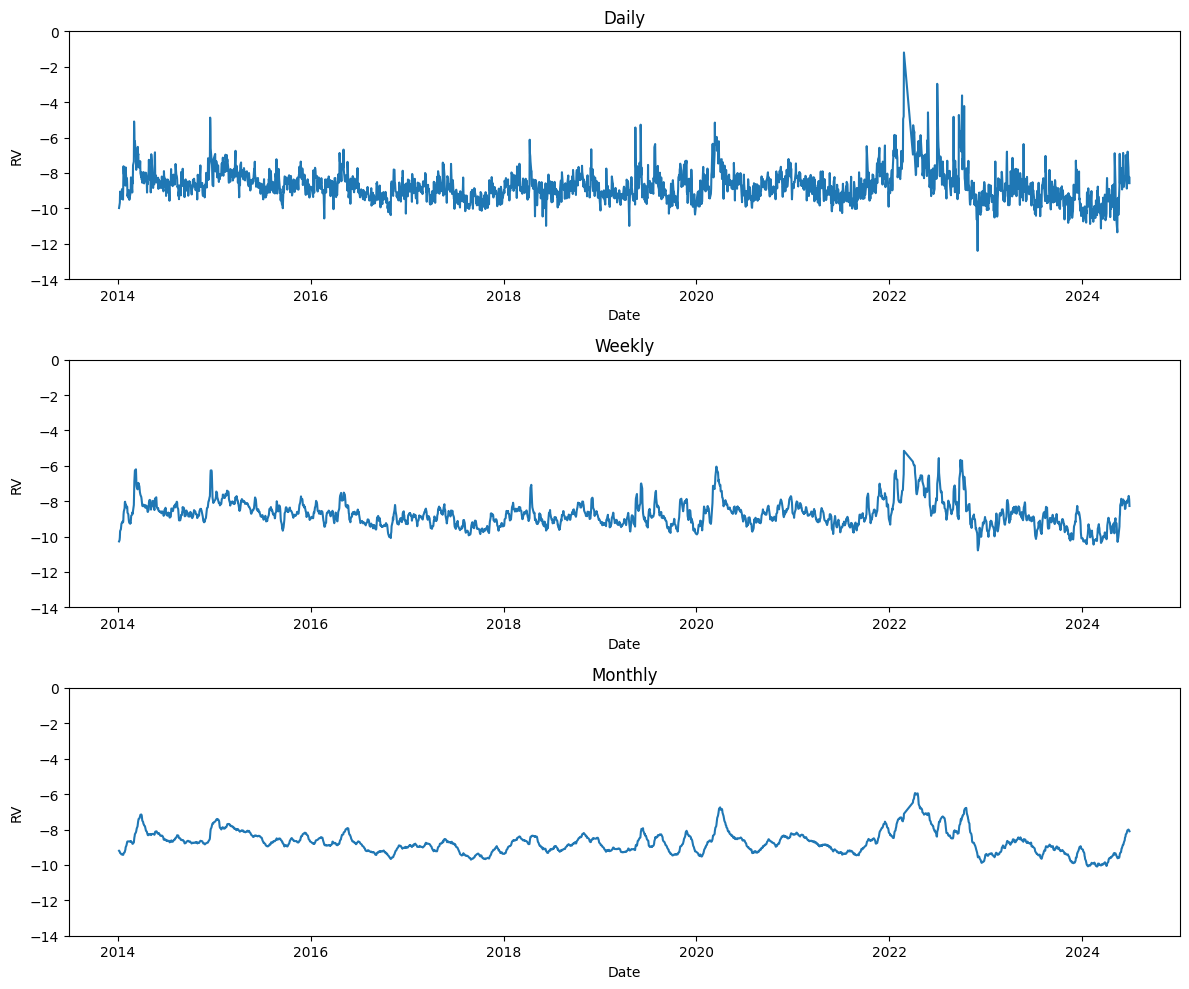

In [36]:
# plotting the 3 rv features, using GAZP
fig, axs = plt.subplots(3, 1)
fig.set_figwidth(12)
fig.set_figheight(10)
for v, i, n in zip(['rv_d_past', 'rv_w_past', 'rv_m_past'], range(3), ['Daily', 'Weekly', 'Monthly']):
    axs[i].plot(data['GAZP'].date, data['GAZP'][v])
    axs[i].set_title(n)
    axs[i].set_ylim(-14, 0)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('RV')
plt.tight_layout()
plt.show()

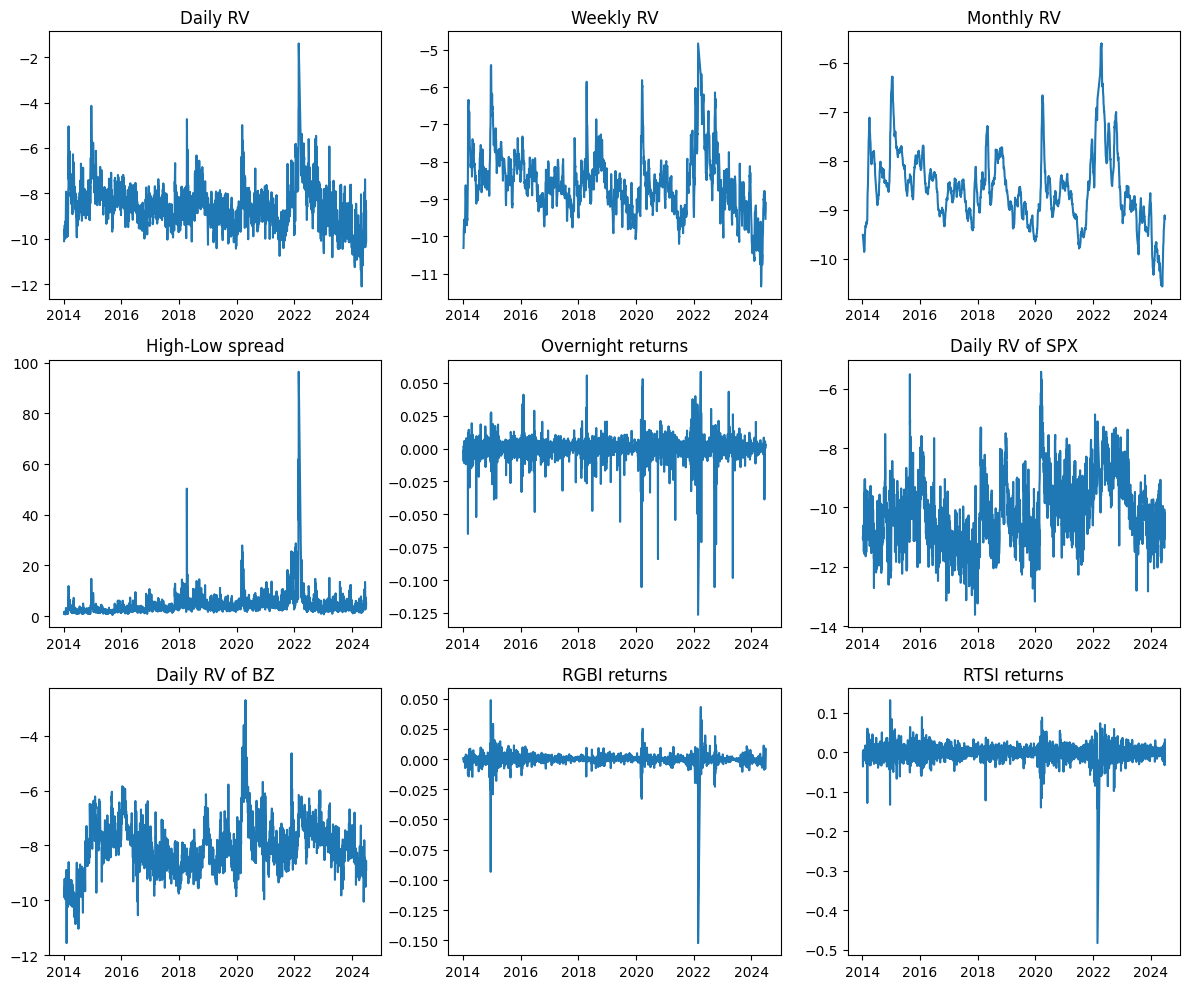

In [52]:
# plotting the features for SBER
titles = ['Daily RV', 'Weekly RV', 'Monthly RV', 
          'High-Low spread', 'Overnight returns', 'Daily RV of SPX',
          'Daily RV of BZ', 'RGBI returns', 'RTSI returns']
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(12)
fig.set_figheight(10)


for i in range(9):
    a, b = i//3, i%3
    axs[a, b].plot(data['SBER'].date, data['SBER'][extended_set[i]])
    axs[a, b].set_title(titles[i])
    #axs[a, b].set_ylim(-14, 0)
    
plt.tight_layout()
plt.show()

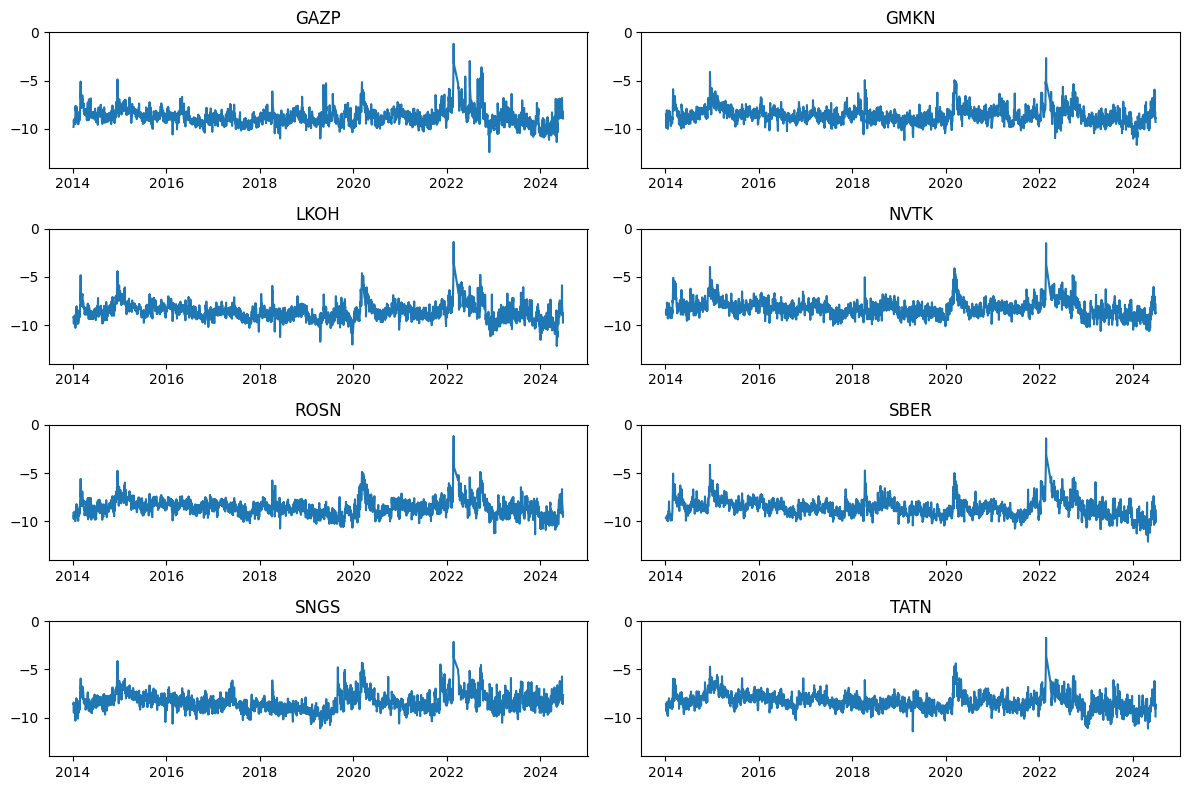

In [65]:
# plotting daily rv per ticker
fig, axs = plt.subplots(4, 2)
fig.set_figwidth(12)
fig.set_figheight(8)
for t, i in zip(ticker_list, range(8)):
    a, b = i//2, i%2
    axs[a, b].plot(data[t].date, data[t].rv_d)
    axs[a, b].set_title(t)
    axs[a, b].set_ylim(-14, 0)
    
plt.tight_layout()
plt.show()

In [75]:
# testing for stationarity
from statsmodels.tsa.stattools import adfuller 
adf_results = {'ticker':[], 'ADF p-value': []}
for t in (ticker_list):
    adf_results['ticker'].append(t)
    adf_results['ADF p-value'].append(adfuller(data[t]['rv_d'].values)[1])
    
print(pd.DataFrame(adf_results).to_latex(float_format=lambda x: f"{x:.{5}e}", index=False))

\begin{tabular}{lr}
\toprule
ticker & ADF p-value \\
\midrule
GAZP & 7.45e-09 \\
GMKN & 3.90e-12 \\
LKOH & 3.35e-08 \\
NVTK & 1.07e-09 \\
ROSN & 1.24e-12 \\
SBER & 1.12e-08 \\
SNGS & 1.24e-04 \\
TATN & 5.72e-11 \\
\bottomrule
\end{tabular}



In [101]:
# creating a table with description of data

descr_results = pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])

for t in (ticker_list):
    descr_results[t] = data[t]['rv_d'].describe().values

print(descr_results.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrrrrr}
\toprule
 & GAZP & GMKN & LKOH & NVTK & ROSN & SBER & SNGS & TATN \\
\midrule
count & 2622.0000 & 2618.0000 & 2622.0000 & 2622.0000 & 2622.0000 & 2622.0000 & 2622.0000 & 2622.0000 \\
mean & -8.7297 & -8.5709 & -8.6316 & -8.2360 & -8.5664 & -8.5887 & -8.3390 & -8.3448 \\
std & 0.8713 & 0.8047 & 0.8805 & 0.8306 & 0.8503 & 0.9158 & 0.9261 & 0.8693 \\
min & -12.4072 & -11.6585 & -12.1619 & -10.6276 & -11.3393 & -12.1012 & -11.1114 & -11.4250 \\
25% & -9.2678 & -9.0718 & -9.1756 & -8.7342 & -9.0967 & -9.1803 & -8.9662 & -8.8956 \\
50% & -8.8036 & -8.6368 & -8.6871 & -8.3008 & -8.6229 & -8.6332 & -8.4398 & -8.3864 \\
75% & -8.3225 & -8.1570 & -8.1901 & -7.8152 & -8.1246 & -8.0988 & -7.8500 & -7.8591 \\
max & -1.1958 & -2.6697 & -1.3895 & -1.5105 & -1.1593 & -1.3975 & -2.1543 & -1.7305 \\
\bottomrule
\end{tabular}



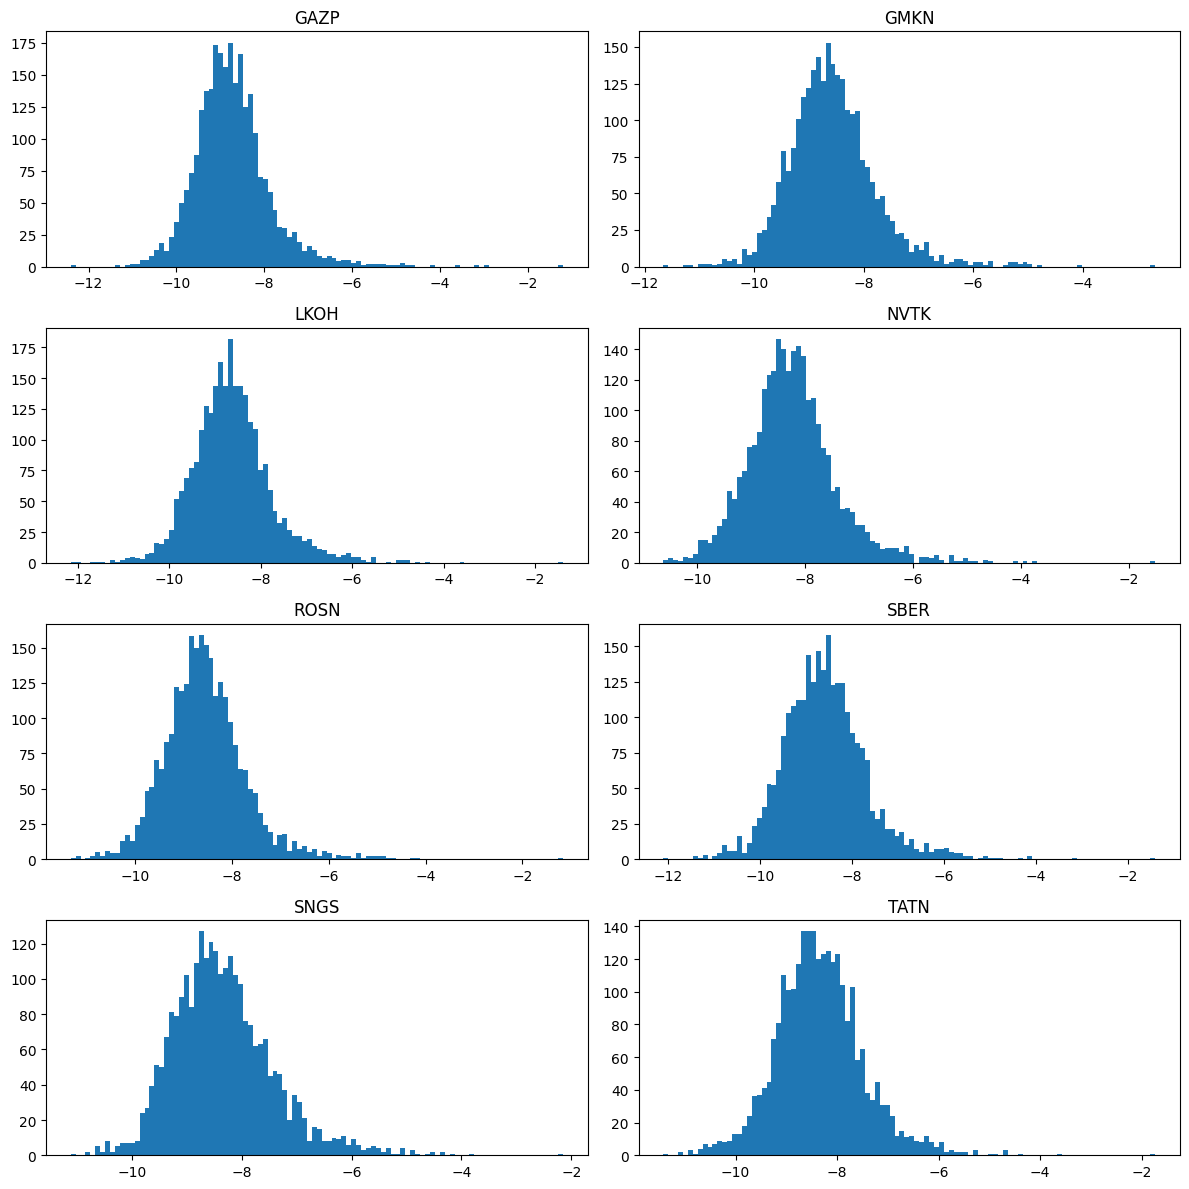

In [79]:
# plotting distribution (of daily rv) per ticker
fig, axs = plt.subplots(4, 2)
fig.set_figwidth(12)
fig.set_figheight(12)
for i, t in enumerate(ticker_list):
    a, b = i//2, i%2
    axs[a, b].hist(data[t].rv_d, bins=100)
    axs[a, b].set_title(t)
plt.tight_layout()
plt.show()